# Natural Language Processing Project - Hate Speech Classification

Conclusion of this project:

I have used two different method for feature engineering:
 (i) Tf-Idf Vectorizer
 (ii) Keras Embedding layer
 
 result for method -1
          Tf-Idf and Logistic Regression              - accuracy score = 93.38 %
          Tf-Idf and Random Forest Classifier         - accuracy score = 93.24 %
          Tf-Idf and Linear Support Vector Classifier - accuracy score = 94.20 %
          
 result for method -2
          Keras Embedding Layer and LSTM model        - accuracy score = 93.09 %
      
 Comparing the accuracy score of different models we can see Tf-Idf and Linear SVC gave us the better result of 94.20%

We have taken two different dataset, 1)imbalance_data in which we have a imbalanced data of hate and no hate speech and 2)raw_data which we are going to do data cleaning and merge with first dataset to make it balanced. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Reading the data
df1 = pd.read_csv(r"D:\ML Projects\NLP-Hate_Dataset/imbalanced_data.csv")
df2 = pd.read_csv(r"D:\ML Projects\NLP-Hate_Dataset/raw_data.csv")

In [3]:
df1.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df2.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# # EDA

In [5]:
import seaborn as sns

<AxesSubplot:xlabel='label', ylabel='count'>

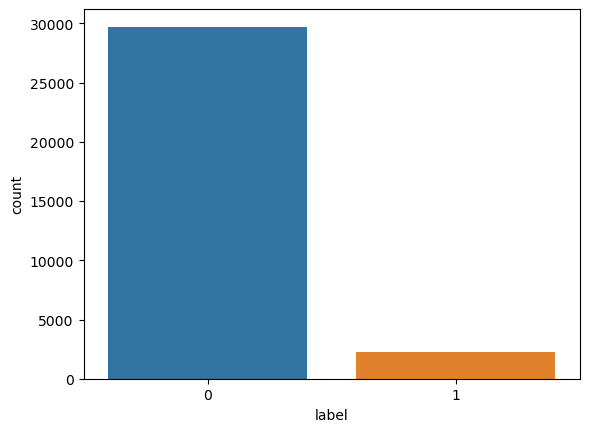

In [6]:
sns.countplot(x='label', data=df1)
#class 0- no hate
#class 1- hate

We can clearly see that the above data is an imbalanced data so to make it balanced data we are going to concatenate df1 and df2.

In [7]:
df1.shape

(31962, 3)

In [8]:
df1.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [9]:
df1.drop("id",axis = 1,inplace = True)

In [10]:
df1.head(3)

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty


In [11]:
df2['class'].value_counts()
#class 0- hate
#class 1- abusive
#class 2- no hate

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [12]:
df2.shape

(24783, 7)

In [13]:
df2.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis = 1,inplace=True)

In [14]:
df2.head(3)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


In [15]:
col = ["label","tweet"]
df2.columns = col

In [16]:
df2.head(3)

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


<AxesSubplot:xlabel='label', ylabel='count'>

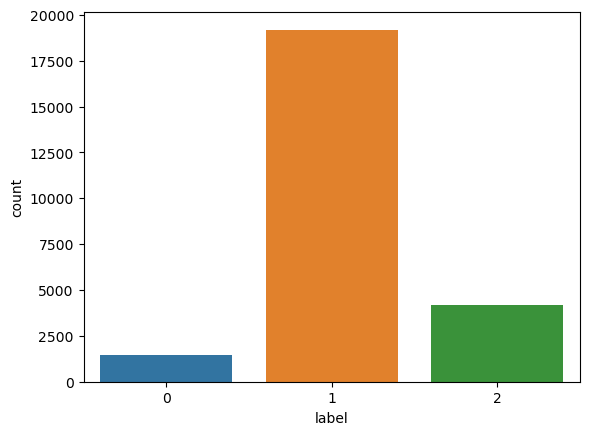

In [17]:
sns.countplot(x='label', data=df2)

In [18]:
# Let's copy the valus of the class 1 into class 0.
df2[df2['label']==0]['label']=1

C:\Users\sriram\AppData\Local\Temp\ipykernel_24364\3063562370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[df2['label']==0]['label']=1


In [19]:
df2['label'].unique()

array([2, 1, 0], dtype=int64)

In [20]:
df2["label"].replace({0:1},inplace=True)

In [21]:
df2['label'].unique()

array([2, 1], dtype=int64)

In [22]:
# Let's replace the value of 2 to 0.
df2["label"].replace({2:0}, inplace = True)

<AxesSubplot:xlabel='label', ylabel='count'>

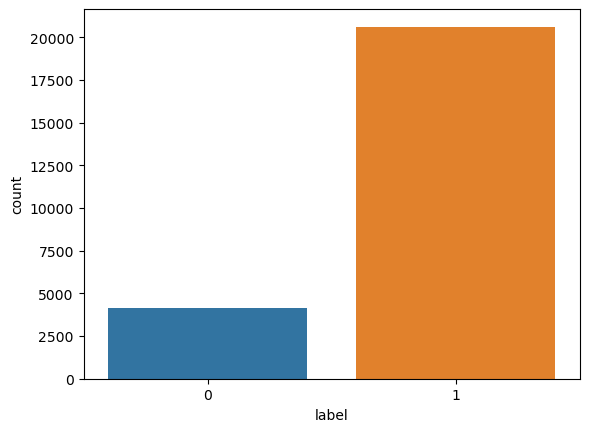

In [23]:
sns.countplot(x='label', data=df2)
#class 0- no hate
#class 1- hate

In [24]:
# Let's concatinate both the data into a single data frame.
frame = [df1, df2]
df = pd.concat(frame)

<AxesSubplot:xlabel='label', ylabel='count'>

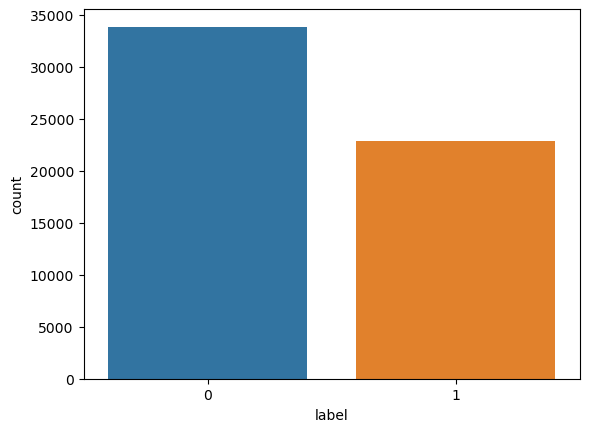

In [25]:
sns.countplot(x='label', data=df)

In [26]:
df.shape

(56745, 2)

In [27]:
df.head(5)

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


# # Preprocessing

In [28]:
import re
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sriram\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [30]:
# Let's apply regex and do cleaning.
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [31]:
df["tweet"][1]

1    @user @user thanks for #lyft credit i can't us...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
Name: tweet, dtype: object

In [32]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [33]:
df["tweet"][1]

1    user user thanks for lyft credit i cant use ca...
1     rt  boy dats coldtyga dwn bad for cuffin dat ...
Name: tweet, dtype: object

In [34]:
x = df['tweet']
y = df['label']

In [35]:
from sklearn.model_selection import train_test_split

# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)

print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

42558 42558
14187 14187


# # Feature Engineering

Part -1 Using Tf-Idf Vectorizer

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

#pipeline for Tf-Idf vectirizer and Logistic Regression model
text_lr = Pipeline([('tfidf', TfidfVectorizer()),('clf', LogisticRegression(solver='lbfgs'))])

#pipeline for Tf-Idf vectirizer and Random Forest Classifier
text_rfc = Pipeline([('tfidf', TfidfVectorizer()),('clf', RandomForestClassifier())])

#pipeline for Tf-Idf vectirizer and Linear Support Vector Classifier
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# # Logistic Regression 

In [38]:
# Feed the training data through the pipeline
text_lr.fit(x_train, y_train) 

# Form a prediction set
y_pred_lr = text_lr.predict(x_test)


#Printing the classification report for logistic regression model
print(classification_report(y_test,y_pred_lr))

#Printing the accuracy score for logistic regression model
print(f"The accuracy of the model is {accuracy_score(y_test,y_pred_lr)}")

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      8453
           1       0.96      0.87      0.91      5734

    accuracy                           0.93     14187
   macro avg       0.94      0.92      0.93     14187
weighted avg       0.94      0.93      0.93     14187

The accuracy of the model is 0.9338831324451963


In [40]:
#Printing the confusion matrix for logistic regression model
con_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_lr), index=['No hate','Hate'], columns=['No hate','Hate'])
con_mat

,No hate,Hate
No hate,8244,209
Hate,729,5005


# # Random Forest Classifier

In [43]:
# Feed the training data through the pipeline
text_rfc.fit(x_train, y_train) 

# Form a prediction set
y_pred_rfc = text_rfc.predict(x_test)

#Printing the confusion matrix for Random Forest model
con_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_rfc), index=['No hate','Hate'], columns=['No hate','Hate'])
print(con_mat)

#Printing the classification report for Random Forest model
print(classification_report(y_test,y_pred_rfc))

#Printing the accuracy score for Random Forest model
print(f"The accuracy of the model is {accuracy_score(y_test,y_pred_rfc)}")

         No hate  Hate
No hate     8065   388
Hate         570  5164
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      8453
           1       0.93      0.90      0.92      5734

    accuracy                           0.93     14187
   macro avg       0.93      0.93      0.93     14187
weighted avg       0.93      0.93      0.93     14187

The accuracy of the model is 0.9324733911327271


# # Linear Support Vector Classifier

In [44]:
# Feed the training data through the pipeline
text_clf.fit(x_train, y_train) 

# Form a prediction set
y_pred_clf = text_clf.predict(x_test)

#Printing the confusion matrix for Linear SVC model
con_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_clf), index=['No hate','Hate'], columns=['No hate','Hate'])
print(con_mat)

#Printing the classification report for Linear SVC model
print(classification_report(y_test,y_pred_clf))

#Printing the accuracy score for Linear SVC model
print(f"The accuracy of the model is {accuracy_score(y_test,y_pred_clf)}")

         No hate  Hate
No hate     8179   274
Hate         548  5186
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      8453
           1       0.95      0.90      0.93      5734

    accuracy                           0.94     14187
   macro avg       0.94      0.94      0.94     14187
weighted avg       0.94      0.94      0.94     14187

The accuracy of the model is 0.9420596320575174


In [88]:
#Testing the model with our own data

sample_text = "I love the world! "
sample_text_new = data_cleaning(sample_text)
sample_text_new = [sample_text_new]

y_pred_ss = text_clf.predict(sample_text_new)

pred_txt = " "
if y_pred_ss == 0:
    pred_txt = "not hate"
else:
    pred_txt = "Hate"
print(f"The text you entered is {sample_text} and the model predicted it as {pred_txt}")

The text you entered is I love the world!  and the model predicted it as not hate


Part -2 Using Keras Embedding layer

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [38]:
max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [39]:
sequences_matrix

array([[    0,     0,     0, ...,   209, 13070,  4452],
       [    0,     0,     0, ...,   248,     3,   653],
       [    0,     0,     0, ...,     1,  1831, 41012],
       ...,
       [ 1126,   669,  2785, ...,   187,     1, 33462],
       [    0,     0,     0, ...,   954, 14416,   774],
       [    0,     0,     0, ...,   419,   378,    13]])

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop

In [41]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [43]:
# starting model training
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 1,validation_split=0.2)

266/266 [==============================] - 331s 1s/step - loss: 0.2727 - accuracy: 0.8998 - val_loss: 0.1691 - val_accuracy: 0.9376


In [44]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [45]:
test_sequences_matrix

array([[   29,  1856,  1260, ...,    13,    11,    29],
       [  471,   192,    31, ...,    16,     3, 17681],
       [    0,     0,     0, ...,   261,   331,  1505],
       ...,
       [    0,     0,     0, ...,    62,    10,   456],
       [    0,     0,     0, ...,     2,     4,     4],
       [    0,     0,     0, ...,     8,    88,  3776]])

In [46]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

444/444 [==============================] - 40s 91ms/step - loss: 0.1850 - accuracy: 0.9310


In [47]:
lstm_prediction = model.predict(test_sequences_matrix)

444/444 [==============================] - 41s 91ms/step


In [48]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

In [49]:
print(confusion_matrix(y_test,res))

[[8153  300]
 [ 679 5055]]


In [50]:
#printing the classification report
print(classification_report(y_test,res))

#Printing the accuracy score 
print(f"The accuracy of the model is {accuracy_score(y_test,res)}")

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      8453
           1       0.94      0.88      0.91      5734

    accuracy                           0.93     14187
   macro avg       0.93      0.92      0.93     14187
weighted avg       0.93      0.93      0.93     14187

The accuracy of the model is 0.9309931627546345


In [102]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [103]:
# Let's save the mdoel.
model.save("model.h5")

In [104]:
import keras

In [105]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [107]:
# Let's test our model on custom data.
test = 'i love this movie'

def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

test=[clean_text(test)]
print(test)

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)

pred = load_model.predict(padded)

print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")

i love this movie
i love this movie
['love movi']
[[28, 5904]]
1/1 [==============================] - 0s 316ms/step
pred [[0.19436294]]
no hate
